## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import re
from datetime import datetime

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from tqdm import tqdm

import pycountry

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True
tqdm.pandas()

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "./data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


In [7]:
data[data['UnitPrice']>=0].min()

InvoiceNo                   536365
StockCode                    10002
Quantity                    -80995
InvoiceDate    2010-12-01 08:26:00
UnitPrice                      0.0
Country                  Australia
dtype: object

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [8]:
data['CustomerID'].nunique()

4372

In [9]:
data[data['Country']!='Unspecified']['Country'].nunique()

37

In [10]:
data['StockCode'].mode()

0    85123A
Name: StockCode, dtype: object

## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [11]:
data.isna().sum().sum()

136534

In [12]:
data.dropna(inplace=True)

data.shape

(406829, 8)

### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [13]:
data.duplicated().sum()

5225

In [14]:
data.drop_duplicates(inplace=True)

data.shape

(401604, 8)

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [15]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [16]:
negative_quantity['check'] = True

negative_quantity['check'] = negative_quantity['InvoiceNo'].progress_apply(lambda x: True if 'C' in x else False)

negative_quantity['check'].value_counts()

100%|██████████| 8872/8872 [00:00<00:00, 634116.61it/s]


True    8872
Name: check, dtype: int64

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [17]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [18]:
from locale import normalize


nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].progress_apply(lambda x: 1 if 'C' in x else 0)

nb_products_per_basket['order_canceled'].value_counts(normalize=True)*100

100%|██████████| 22190/22190 [00:00<00:00, 528362.63it/s]


0    83.533123
1    16.466877
Name: order_canceled, dtype: float64

Давайте поближе взглянем на отмененные заказы:


In [19]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [20]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакцию в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



In [21]:
for ind in tqdm(negative_quantity.index):
    tmp_record = negative_quantity.loc[ind]
    mask = (data['CustomerID'] == tmp_record['CustomerID'])&(data['StockCode'] == tmp_record['StockCode'])&(data['StockCode'] == tmp_record['StockCode'])
    tmp_data_record = data[mask]
    if tmp_data_record.Quantity.sum() != 0:
        print('Гипотеза не выполняется.')
        break
else:
    print('Гипотеза подтверждена.')

  0%|          | 0/8872 [00:00<?, ?it/s]

Гипотеза не выполняется.


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [22]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [23]:
for ind in tqdm(negative_quantity[negative_quantity['StockCode']!='D'].index):
    tmp_record = negative_quantity.loc[ind]
    mask = (data['CustomerID'] == tmp_record['CustomerID'])&(data['StockCode'] == tmp_record['StockCode'])&(data['StockCode'] == tmp_record['StockCode'])
    tmp_data_record = data[mask]
    if tmp_data_record.Quantity.sum() != 0:
        print('Гипотеза не выполняется.')
        break
else:
    print('Гипотеза подтверждена.')

  0%|          | 0/8795 [00:00<?, ?it/s]

Гипотеза не выполняется.


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [24]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [25]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
data['QuantityCanceled'] = quantity_canceled

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [26]:
data['QuantityCanceled'].sum()

245266.0

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [27]:
data[data['QuantityCanceled']==0].shape[0]

394388

In [28]:
data.drop(index=negative_quantity.index).shape[0]

392732

In [29]:
data_cleared = data.drop(index=negative_quantity.index)
# data_cleared = data[data['QuantityCanceled']==0]

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [30]:
data_cleared[data_cleared['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)]['StockCode'].nunique()

6

In [31]:
data_cleared = data_cleared.drop(data_cleared[data_cleared['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)].index)

data_cleared.shape

(391183, 9)

### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [32]:
data_cleared[data_cleared['UnitPrice'] == 0].shape[0]

33

In [33]:
data_cleared = data_cleared.drop(data_cleared[data_cleared['UnitPrice'] == 0].index)

In [34]:
data_cleared.shape[0]

391150

Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [35]:
customer_distribution = data_cleared.groupby(by='Country', as_index=False)['CustomerID'].nunique().sort_values(by='CustomerID',ascending=False)

In [36]:
convert_ISO_3166_2_to_1 = {
'AF':'AFG',
'AX':'ALA',
'AL':'ALB',
'DZ':'DZA',
'AS':'ASM',
'AD':'AND',
'AO':'AGO',
'AI':'AIA',
'AQ':'ATA',
'AG':'ATG',
'AR':'ARG',
'AM':'ARM',
'AW':'ABW',
'AU':'AUS',
'AT':'AUT',
'AZ':'AZE',
'BS':'BHS',
'BH':'BHR',
'BD':'BGD',
'BB':'BRB',
'BY':'BLR',
'BE':'BEL',
'BZ':'BLZ',
'BJ':'BEN',
'BM':'BMU',
'BT':'BTN',
'BO':'BOL',
'BA':'BIH',
'BW':'BWA',
'BV':'BVT',
'BR':'BRA',
'IO':'IOT',
'BN':'BRN',
'BG':'BGR',
'BF':'BFA',
'BI':'BDI',
'KH':'KHM',
'CM':'CMR',
'CA':'CAN',
'CV':'CPV',
'KY':'CYM',
'CF':'CAF',
'TD':'TCD',
'CL':'CHL',
'CN':'CHN',
'CX':'CXR',
'CC':'CCK',
'CO':'COL',
'KM':'COM',
'CG':'COG',
'CD':'COD',
'CK':'COK',
'CR':'CRI',
'CI':'CIV',
'HR':'HRV',
'CU':'CUB',
'CY':'CYP',
'CZ':'CZE',
'DK':'DNK',
'DJ':'DJI',
'DM':'DMA',
'DO':'DOM',
'EC':'ECU',
'EG':'EGY',
'SV':'SLV',
'GQ':'GNQ',
'ER':'ERI',
'EE':'EST',
'ET':'ETH',
'FK':'FLK',
'FO':'FRO',
'FJ':'FJI',
'FI':'FIN',
'FR':'FRA',
'GF':'GUF',
'PF':'PYF',
'TF':'ATF',
'GA':'GAB',
'GM':'GMB',
'GE':'GEO',
'DE':'DEU',
'GH':'GHA',
'GI':'GIB',
'GR':'GRC',
'GL':'GRL',
'GD':'GRD',
'GP':'GLP',
'GU':'GUM',
'GT':'GTM',
'GG':'GGY',
'GN':'GIN',
'GW':'GNB',
'GY':'GUY',
'HT':'HTI',
'HM':'HMD',
'VA':'VAT',
'HN':'HND',
'HK':'HKG',
'HU':'HUN',
'IS':'ISL',
'IN':'IND',
'ID':'IDN',
'IR':'IRN',
'IQ':'IRQ',
'IE':'IRL',
'IM':'IMN',
'IL':'ISR',
'IT':'ITA',
'JM':'JAM',
'JP':'JPN',
'JE':'JEY',
'JO':'JOR',
'KZ':'KAZ',
'KE':'KEN',
'KI':'KIR',
'KP':'PRK',
'KR':'KOR',
'KW':'KWT',
'KG':'KGZ',
'LA':'LAO',
'LV':'LVA',
'LB':'LBN',
'LS':'LSO',
'LR':'LBR',
'LY':'LBY',
'LI':'LIE',
'LT':'LTU',
'LU':'LUX',
'MO':'MAC',
'MK':'MKD',
'MG':'MDG',
'MW':'MWI',
'MY':'MYS',
'MV':'MDV',
'ML':'MLI',
'MT':'MLT',
'MH':'MHL',
'MQ':'MTQ',
'MR':'MRT',
'MU':'MUS',
'YT':'MYT',
'MX':'MEX',
'FM':'FSM',
'MD':'MDA',
'MC':'MCO',
'MN':'MNG',
'ME':'MNE',
'MS':'MSR',
'MA':'MAR',
'MZ':'MOZ',
'MM':'MMR',
'NA':'NAM',
'NR':'NRU',
'NP':'NPL',
'NL':'NLD',
'AN':'ANT',
'NC':'NCL',
'NZ':'NZL',
'NI':'NIC',
'NE':'NER',
'NG':'NGA',
'NU':'NIU',
'NF':'NFK',
'MP':'MNP',
'NO':'NOR',
'OM':'OMN',
'PK':'PAK',
'PW':'PLW',
'PS':'PSE',
'PA':'PAN',
'PG':'PNG',
'PY':'PRY',
'PE':'PER',
'PH':'PHL',
'PN':'PCN',
'PL':'POL',
'PT':'PRT',
'PR':'PRI',
'QA':'QAT',
'RE':'REU',
'RO':'ROU',
'RU':'RUS',
'RW':'RWA',
'BL':'BLM',
'SH':'SHN',
'KN':'KNA',
'LC':'LCA',
'MF':'MAF',
'PM':'SPM',
'VC':'VCT',
'WS':'WSM',
'SM':'SMR',
'ST':'STP',
'SA':'SAU',
'SN':'SEN',
'RS':'SRB',
'SC':'SYC',
'SL':'SLE',
'SG':'SGP',
'SK':'SVK',
'SI':'SVN',
'SB':'SLB',
'SO':'SOM',
'ZA':'ZAF',
'GS':'SGS',
'ES':'ESP',
'LK':'LKA',
'SD':'SDN',
'SR':'SUR',
'SJ':'SJM',
'SZ':'SWZ',
'SE':'SWE',
'CH':'CHE',
'SY':'SYR',
'TW':'TWN',
'TJ':'TJK',
'TZ':'TZA',
'TH':'THA',
'TL':'TLS',
'TG':'TGO',
'TK':'TKL',
'TO':'TON',
'TT':'TTO',
'TN':'TUN',
'TR':'TUR',
'TM':'TKM',
'TC':'TCA',
'TV':'TUV',
'UG':'UGA',
'UA':'UKR',
'AE':'ARE',
'GB':'GBR',
'US':'USA',
'UM':'UMI',
'UY':'URY',
'UZ':'UZB',
'VU':'VUT',
'VE':'VEN',
'VN':'VNM',
'VG':'VGB',
'VI':'VIR',
'WF':'WLF',
'EH':'ESH',
'YE':'YEM',
'ZM':'ZMB',
'ZW':'ZWE'
}

In [37]:
input_countries = ['American Samoa', 'Canada', 'France']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

customer_distribution['iso_alpha'] = customer_distribution['Country'].apply(lambda x: countries.get(x, 'Unknown code'))
customer_distribution['iso_alpha'] = customer_distribution['iso_alpha'].apply(lambda x: convert_ISO_3166_2_to_1.get(x, 'Unknown code'))

In [38]:
customer_distribution.head(3)

,Country,CustomerID,iso_alpha
35,United Kingdom,3916,GBR
14,Germany,94,DEU
13,France,87,FRA


In [39]:
fig = px.choropleth(customer_distribution, locations='iso_alpha', color='CustomerID')
fig.show()

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [40]:
orders_distribution = data_cleared.groupby(by='Country', as_index=False)['InvoiceNo'].nunique().sort_values(by='InvoiceNo', ascending=False)

orders_distribution['iso_alpha'] = orders_distribution['Country'].apply(lambda x: countries.get(x, 'Unknown code'))
orders_distribution['iso_alpha'] = orders_distribution['iso_alpha'].apply(lambda x: convert_ISO_3166_2_to_1.get(x, 'Unknown code'))

In [41]:
orders_distribution.head(3)

,Country,InvoiceNo,iso_alpha
35,United Kingdom,16579,GBR
14,Germany,443,DEU
13,France,379,FRA


In [42]:
fig = px.choropleth(orders_distribution, locations='iso_alpha', color='InvoiceNo')
fig.show()

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [43]:
data_cleared['TotalPrice'] = (data_cleared['Quantity'] - data_cleared['QuantityCanceled']) * data_cleared['UnitPrice']

data_cleared['TotalPrice'].mean()

21.126404167208413

### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [44]:
income_distribution = data_cleared.groupby(by='Country', as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)

income_distribution['iso_alpha'] = income_distribution['Country'].apply(lambda x: countries.get(x, 'Unknown code'))
income_distribution['iso_alpha'] = income_distribution['iso_alpha'].apply(lambda x: convert_ISO_3166_2_to_1.get(x, 'Unknown code'))

income_distribution.head(3)

,Country,TotalPrice,iso_alpha
35,United Kingdom,6797691.44,GBR
23,Netherlands,283443.54,NLD
10,EIRE,247074.57,Unknown code


In [45]:
fig = px.choropleth(income_distribution, locations='iso_alpha', color='TotalPrice')
fig.show()

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

In [46]:
data_cleared['month'] = data_cleared['InvoiceDate'].dt.month
data_cleared['day_of_week'] = data_cleared['InvoiceDate'].dt.day_of_week
data_cleared['hour'] = data_cleared['InvoiceDate'].dt.hour

In [47]:
income_by_month = data_cleared.groupby(by='month')['TotalPrice'].sum().sort_values(ascending=False)

income_by_month

month
11    1119641.60
10     967436.46
9      928554.44
12     894126.86
5      647403.81
8      614704.38
6      601238.45
7      581019.35
3      571941.01
1      453560.68
4      447922.86
2      436043.09
Name: TotalPrice, dtype: float64

<AxesSubplot:xlabel='month', ylabel='TotalPrice'>

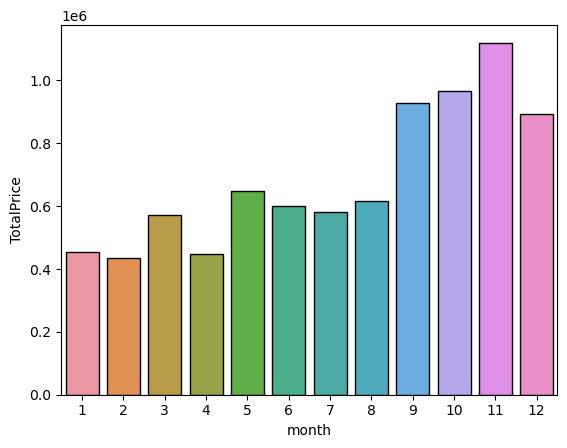

In [48]:
sns.barplot(y=income_by_month,x=income_by_month.index)

**Наблюдение:** люди покупают подарки перед новогодними праздниками и рождеством для близких и коллег.

### Задание 4.6
Постройте визуализацию, отражающую распределение среднего количества заказов по дням недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье


In [49]:
weekday_order_count = data_cleared.groupby(by='day_of_week')['InvoiceNo'].nunique().sort_values(ascending=False)

<AxesSubplot:xlabel='day_of_week', ylabel='InvoiceNo'>

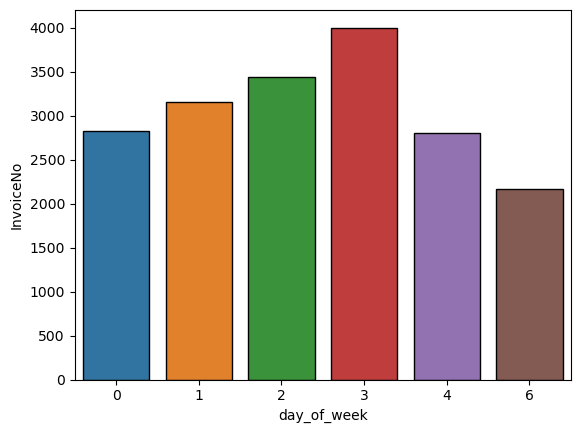

In [50]:
sns.barplot(y=weekday_order_count,x=weekday_order_count.index)

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


In [51]:
data_cleared['OrderDate'] = data_cleared['InvoiceDate'].dt.date

In [52]:
time_data_groupped = data_cleared.groupby(
    by=['OrderDate','hour'],
    as_index=False
)['InvoiceNo'].nunique().groupby(
    by=['hour'],
    as_index=False
).mean().round(2)

In [53]:
time_data_groupped

,hour,InvoiceNo
0,6,1.00
1,7,1.26
2,8,2.72
3,9,5.49
4,10,7.27
5,11,7.44
6,12,10.22
7,13,8.69
8,14,7.48
9,15,6.71


<AxesSubplot:xlabel='hour', ylabel='InvoiceNo'>

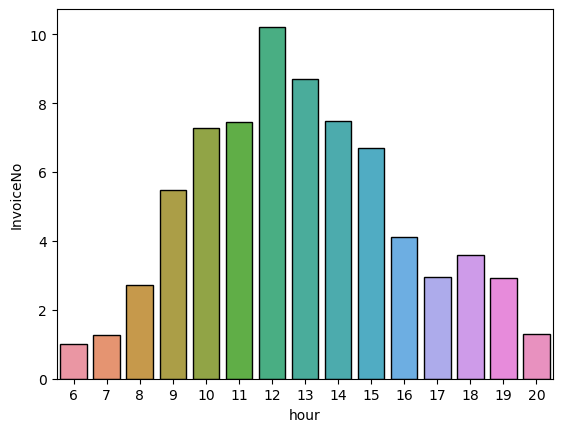

In [54]:
sns.barplot(y=time_data_groupped.InvoiceNo,x=time_data_groupped.hour)

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-ого клиента рассчитывается как разница между датой последнего заказа и точкой отсчета, переведенная в дни:
 $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ - дата совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчета $t_0$ берем дату на 1 день "старше", чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime - '2011-12-10').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [55]:
data_cleared

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,month,day_of_week,hour,OrderDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,12,2,8,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00,12,2,8,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,0.0,10.20,12,4,12,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,0.0,12.60,12,4,12,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,0.0,16.60,12,4,12,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,0.0,16.60,12,4,12,2011-12-09


In [56]:
rfm_table = data_cleared.groupby(
    by='CustomerID',
    # as_index=False
    ).agg(
        {
            'InvoiceNo':'nunique',
            'TotalPrice':'sum',
            'InvoiceDate':'max'
         }
        ).rename(
            columns={
                'InvoiceDate':'Recency',
                'TotalPrice':'Monetary Value',
                'InvoiceNo':'Frequency',
                }
            )

rfm_table['Recency'] = rfm_table['Recency'].apply(
                # lambda x: (datetime.strptime('2011-12-10', '%Y-%m-%d').date() -  x).days
                lambda x: (pd.to_datetime('2011-12-10') -  x).days
                )

rfm_table

,Frequency,Monetary Value,Recency
CustomerID,,,
12346,1,0.00,325
12347,7,4310.00,2
12348,4,1437.24,75
12349,1,1457.55,18
12350,1,294.40,310
...,...,...,...
18280,1,180.60,277
18281,1,80.82,180
18282,2,176.60,7


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [57]:
rfm_table[rfm_table['Recency']>200]

,Frequency,Monetary Value,Recency
CustomerID,,,
12346,1,0.00,325
12350,1,294.40,310
12353,1,89.00,204
12354,1,1079.40,232
12355,1,459.40,214
...,...,...,...
18233,1,440.00,325
18239,5,1561.61,218
18250,1,342.92,310


In [58]:
rfm_table['Frequency'].mean()

4.2459621596677435

In [59]:
rfm_table.loc['12360']

Frequency            3.00
Monetary Value    2302.06
Recency             52.00
Name: 12360, dtype: float64

Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [60]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Frequency","Monetary Value", "Recency"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [61]:
drop_index = list(rfm_table[rfm_table['Frequency']>rfm_table['Frequency'].quantile(0.95)].index) + list(rfm_table[rfm_table['Monetary Value']>rfm_table['Monetary Value'].quantile(0.95)].index)

rfm_table_cleaned = rfm_table.drop(drop_index)

rfm_table_cleaned.shape

(4044, 3)

После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [62]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Frequency","Monetary Value", "Recency"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


In [63]:
rfm_table_cleaned

,Frequency,Monetary Value,Recency
CustomerID,,,
12346,1,0.00,325
12347,7,4310.00,2
12348,4,1437.24,75
12349,1,1457.55,18
12350,1,294.40,310
...,...,...,...
18278,1,173.90,73
18280,1,180.60,277
18281,1,80.82,180


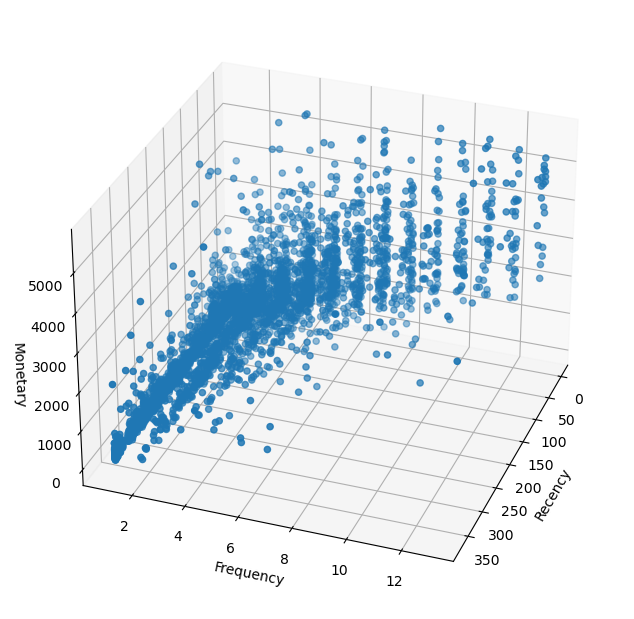

In [64]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary Value'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [65]:
estimators = [
    ('scaler', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=2))
]
pipe = pipeline.Pipeline(estimators)

rfm_table_processed = pd.DataFrame(data=pipe.fit_transform(rfm_table_cleaned), columns=['axis-1','axis-2'])

In [66]:
pipe[1].explained_variance_ratio_[0]

0.6774705317186048

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

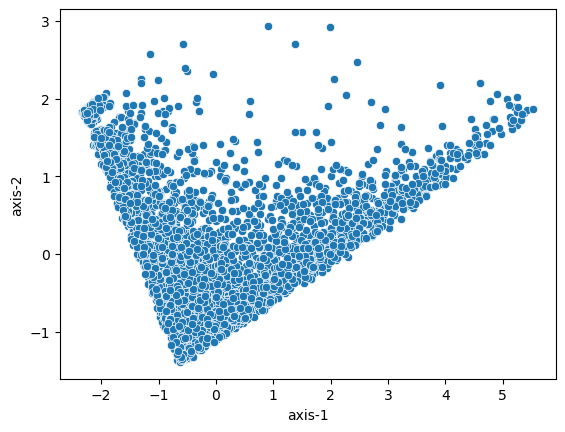

In [67]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2')

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


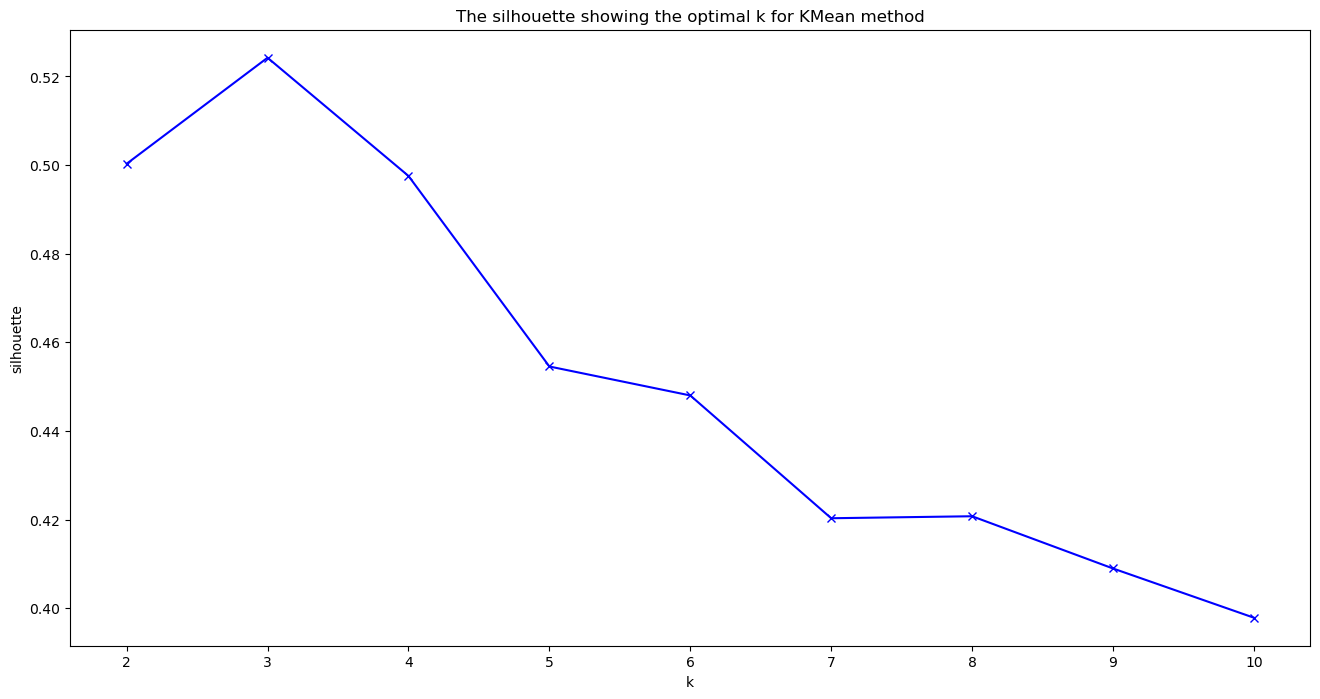

In [68]:
silhouette = []

K = range(2,11)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(rfm_table_processed)
    labels = kmeanModel.predict(rfm_table_processed)
    silhouette.append(metrics.silhouette_score(rfm_table_processed, labels=labels))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('The silhouette showing the optimal k for KMean method')
plt.show()

In [69]:
max(silhouette)

0.5242296656541479

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


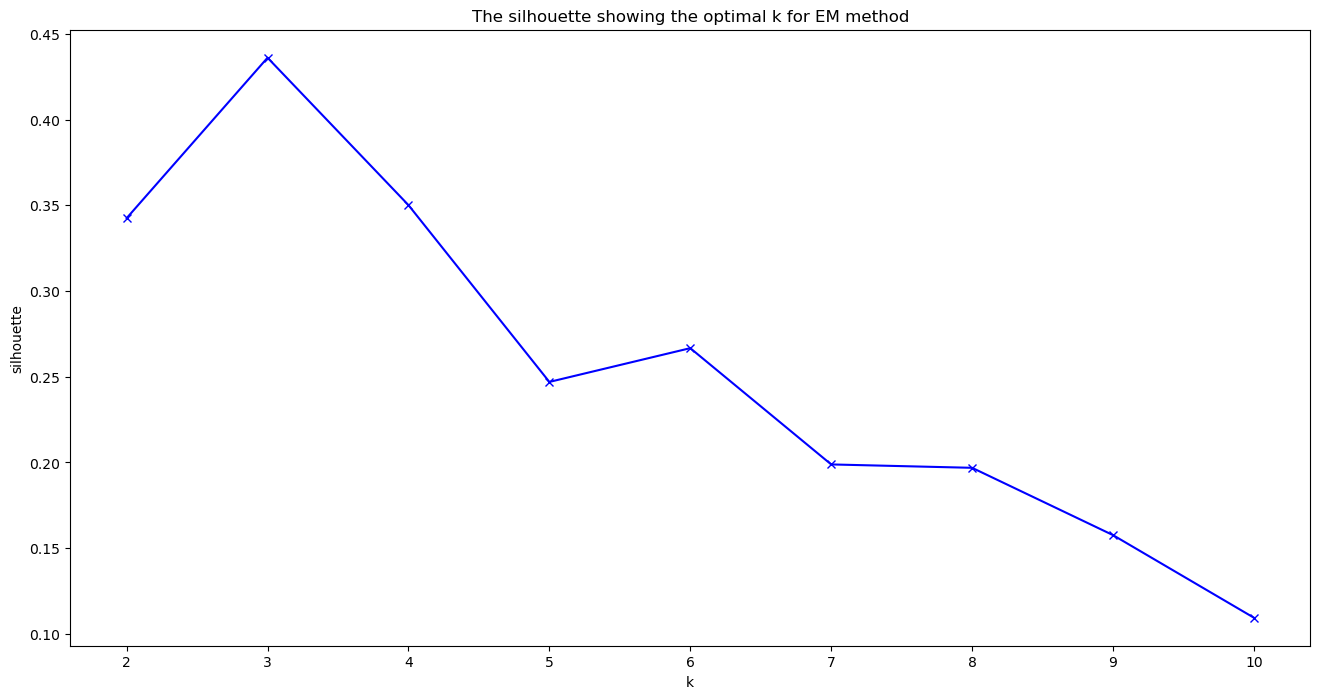

In [70]:
silhouette = []

K = range(2,11)
for k in K:
    kmeanModel = mixture.GaussianMixture(n_components=k, random_state=42)
    kmeanModel.fit(rfm_table_processed)
    labels = kmeanModel.predict(rfm_table_processed)
    silhouette.append(metrics.silhouette_score(rfm_table_processed, labels=labels))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('The silhouette showing the optimal k for EM method')
plt.show()

In [71]:
max(silhouette)

0.4360614977265809

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [72]:
kmean = cluster.KMeans(n_clusters=3, random_state=42)

labels = kmean.fit_predict(rfm_table_processed)

Визуализируем результаты кластеризации:

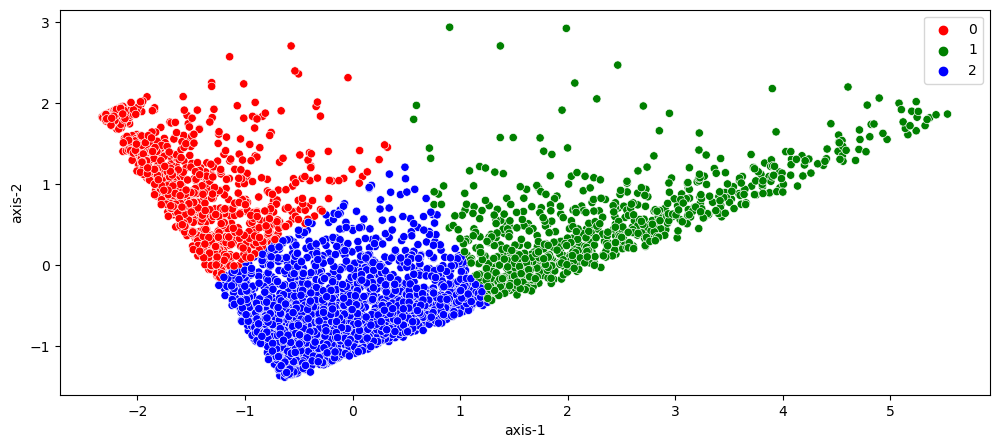

In [73]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
    palette=['red', 'green', 'blue']
);

In [74]:
np.unique(labels, return_counts= True)

(array([0, 1, 2]), array([ 999,  776, 2269], dtype=int64))

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [75]:
rfm_table_cleaned['kmean'] = labels

rfm_table_meaned = rfm_table_cleaned.groupby('kmean').mean()

rfm_table_meaned

,Frequency,Monetary Value,Recency
kmean,,,
0,1.403403,386.277297,253.474474
1,7.068299,2657.746997,31.943299
2,2.329220,660.068947,51.221684


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [76]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [77]:
plot_cluster_profile(rfm_table_meaned, 3)

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [78]:
rfm_table_cleaned.drop('kmean', inplace=True, axis=1)

In [79]:
sne_pipe = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('tsne', manifold.TSNE(n_components=2, perplexity=50.0, random_state=100))
    ]
)
rfm_table_processed = sne_pipe.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)
print(round(sne_pipe['tsne'].kl_divergence_, 2))

0.55


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

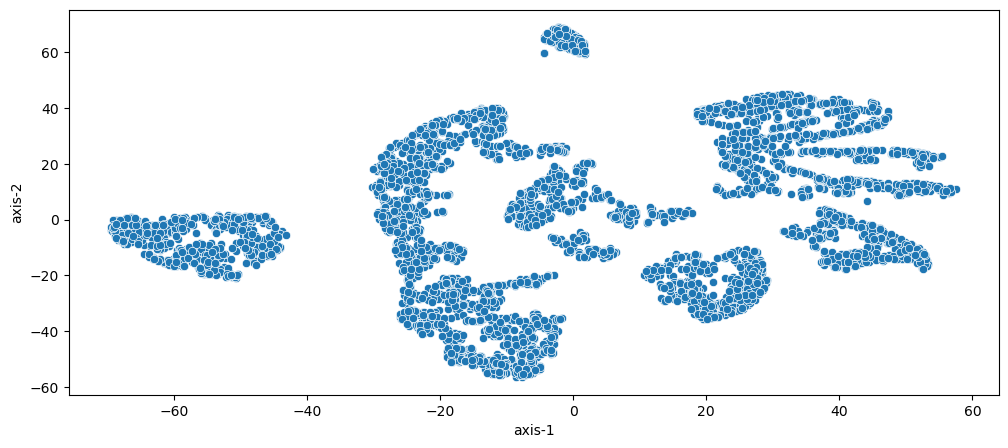

In [80]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2')

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



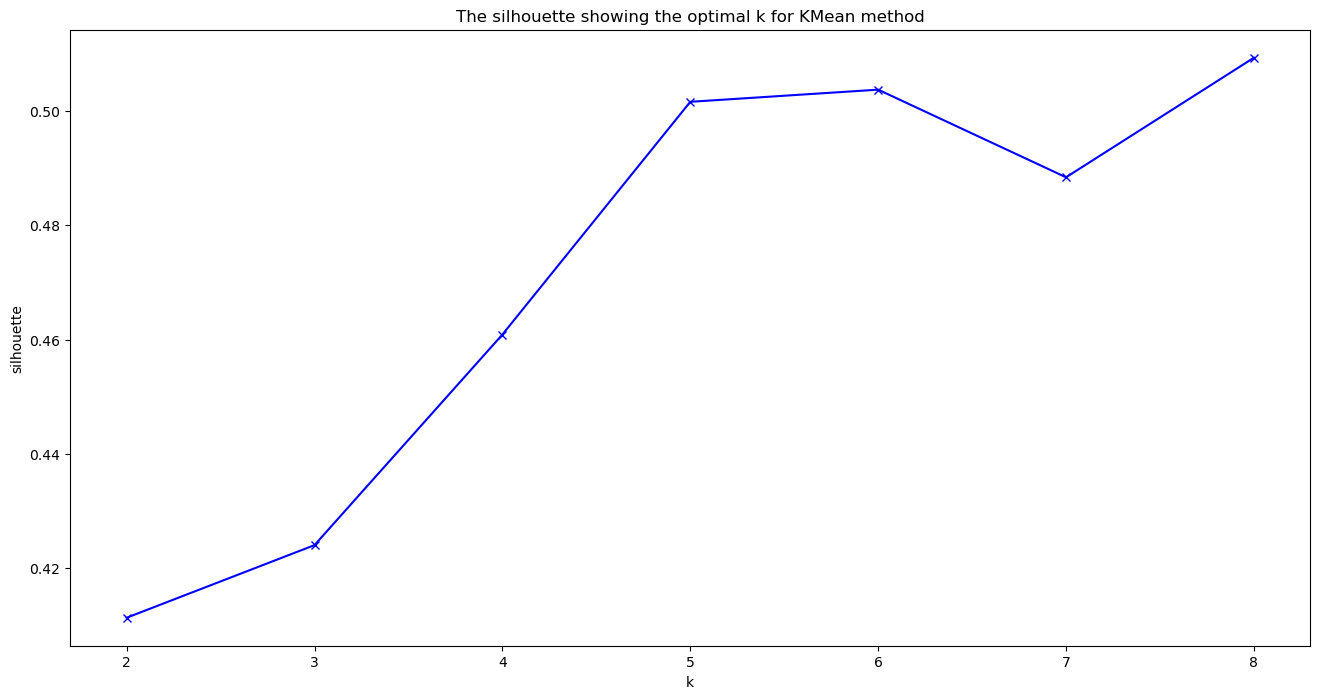

In [81]:
silhouette = []

K = range(2,9)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(rfm_table_processed)
    labels = kmeanModel.predict(rfm_table_processed)
    silhouette.append(metrics.silhouette_score(rfm_table_processed, labels=labels))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('The silhouette showing the optimal k for KMean method')
plt.show()

In [82]:
max(silhouette)

0.5093719

### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

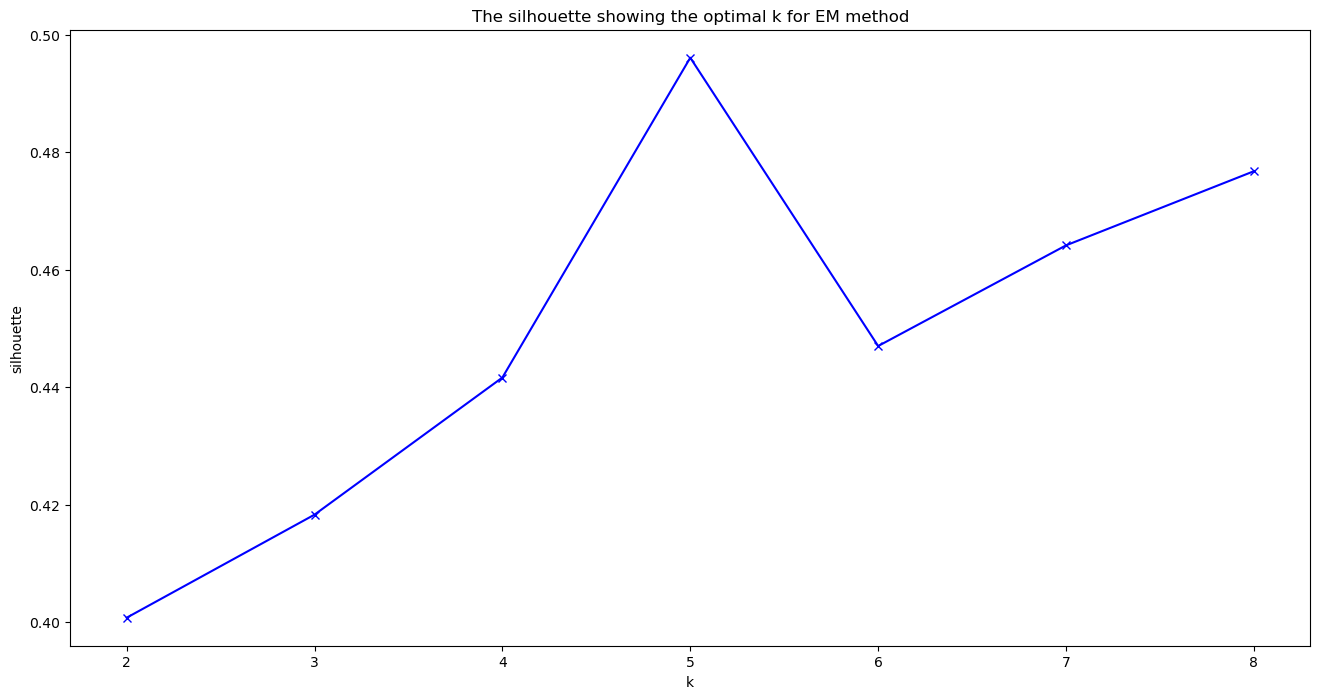

In [83]:
silhouette = []

K = range(2,9)
for k in K:
    kmeanModel = mixture.GaussianMixture(n_components=k, random_state=42)
    kmeanModel.fit(rfm_table_processed)
    labels = kmeanModel.predict(rfm_table_processed)
    silhouette.append(metrics.silhouette_score(rfm_table_processed, labels=labels))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('The silhouette showing the optimal k for EM method')
plt.show()

In [84]:
max(silhouette)

0.49610046

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



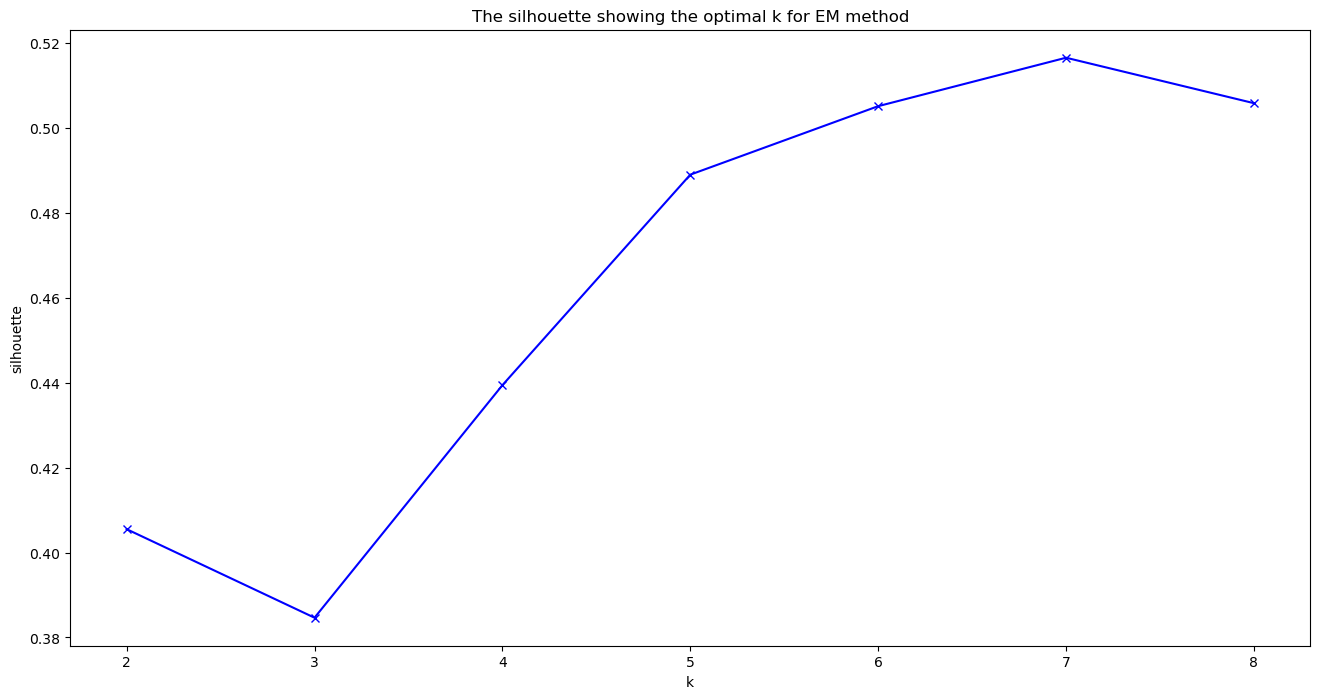

In [85]:
silhouette = []

K = range(2,9)
for k in K:
    algo = cluster.AgglomerativeClustering(n_clusters=k)
    labels = algo.fit_predict(rfm_table_processed)
    silhouette.append(metrics.silhouette_score(rfm_table_processed, labels=labels))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('The silhouette showing the optimal k for EM method')
plt.show()

In [86]:
max(silhouette)

0.51657736

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [87]:
model = cluster.AgglomerativeClustering(n_clusters=7)
labels = algo.fit_predict(rfm_table_processed)
silhouette.append(metrics.silhouette_score(rfm_table_processed, labels=labels))

In [88]:
labels

array([2, 1, 7, ..., 0, 3, 5], dtype=int64)

Визуализируем результаты кластеризации:

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

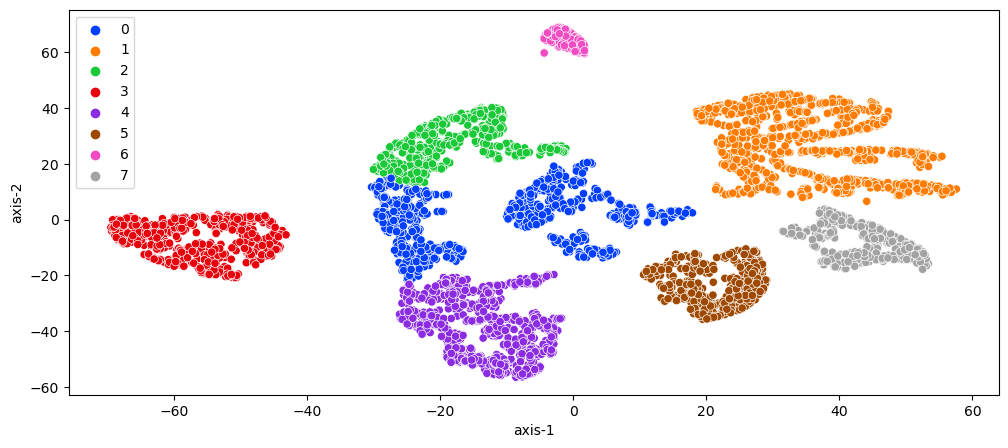

In [89]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=labels, palette='bright')

In [90]:
rfm_table_processed['labels'] = labels

rfm_table_processed.groupby('labels').count().max()

axis-1    904
axis-2    904
dtype: int64


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [91]:
rfm_table_cleaned['labels'] = labels

rfm_table_meaned = rfm_table_cleaned.groupby('labels').mean()

rfm_table_meaned.max()

Frequency            6.803097
Monetary Value    2418.338960
Recency            365.456140
dtype: float64

### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [92]:
plot_cluster_profile(rfm_table_meaned, 7)

In [94]:
rfm_table_cleaned.drop('labels', axis=1, inplace=True)

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [95]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned #очищенная RFM-таблица
y = labels #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

X_test.shape[0]

809

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [97]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

rf = ensemble.RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1)

clf = model_selection.GridSearchCV(rf, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

clf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15),
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=1)

In [98]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 500}

In [99]:
rf = ensemble.RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1, **clf.best_params_)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


0.9864029666254636

Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [105]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

gbc = ensemble.GradientBoostingClassifier(random_state=42, verbose=1)

clf = model_selection.GridSearchCV(gbc, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

clf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
      Iter       Train Loss   Remaining Time 
         1           1.3245            3.66s
         2           1.0309            4.17s
         3           0.8266            4.43s
         4           0.6734            4.34s
         5           0.5540            4.43s
         6           0.4589            4.62s
         7           0.3819            4.60s
         8           0.3191            4.62s
         9           0.2674            4.56s
        10           0.2246            4.62s
        20           0.0426            4.26s
        30           0.0091            4.14s
        40           0.0022            3.74s
        50           0.0006            3.17s
        60           0.0002            2.57s
        70           0.0001            1.91s
        80           0.0000            1.25s
        90           0.0000            0.62s
       100           0.0000            0.00s


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(3, 7),
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=1)

In [107]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [108]:
gbc = ensemble.GradientBoostingClassifier(random_state=42, verbose=1, **clf.best_params_)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

      Iter       Train Loss   Remaining Time 
         1           1.3245            3.76s
         2           1.0309            4.75s
         3           0.8266            5.14s
         4           0.6734            5.30s
         5           0.5540            5.40s
         6           0.4589            5.95s
         7           0.3819            6.51s
         8           0.3191            6.40s
         9           0.2674            6.18s
        10           0.2246            5.93s
        20           0.0426            4.89s
        30           0.0091            4.18s
        40           0.0022            3.57s
        50           0.0006            2.93s
        60           0.0002            2.33s
        70           0.0001            1.75s
        80           0.0000            1.16s
        90           0.0000            0.59s
       100           0.0000            0.00s


0.9901112484548825

Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.